In [2]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f0c7et0p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-f0c7et0p
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
pip install torch torchvision


Import all the necessary libraries

In [4]:
import os
import numpy as np
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, RepeatVector, Dot, Activation, Lambda, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import tensorflow as tf

Write the input and output directories. They are stored in Google Drive

In [5]:
# Directories for input/output
INPUT_DIR = '/content/drive/MyDrive/Vision-Language-Model'
OUTPUT_DIR = '/content/drive/MyDrive/Vision-Language-Model/Output'

if not os.path.exists(INPUT_DIR):
    raise FileNotFoundError("Input directory not found")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Load a clip model. Preprocess the image features and convert to tensor format

In [6]:
# Load CLIP model and preprocessing pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Image Preprocessing
clip_preprocess = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 84.5MiB/s]


Preprocessing image features

In [7]:
# Extract image features using CLIP
img_dir = os.path.join(INPUT_DIR, 'Images')
clip_image_features = {}

for img_name in tqdm(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feature = clip_model.encode_image(img_tensor).cpu().numpy()
    img_id = img_name.split('.')[0]
    clip_image_features[img_id] = img_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# Save image features
with open(os.path.join(OUTPUT_DIR, "clip_image_features.pkl"), "wb") as f:
    pickle.dump(clip_image_features, f)

In [9]:
# Load image features
with open(os.path.join(OUTPUT_DIR, "clip_image_features.pkl"), "rb") as f:
    loaded_features = pickle.load(f)

In [10]:
# Captions Mapping
image_to_caption_mapping = defaultdict(list)
captions_doc_path = os.path.join(INPUT_DIR, 'captions.txt')

Find image to caption mapping

In [11]:
with open(captions_doc_path, 'r') as f:
    captions_doc = f.read()

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    image_id = image_id.split('.')[0]
    caption = " ".join(captions)
    image_to_caption_mapping[image_id].append(caption)

  0%|          | 0/40457 [00:00<?, ?it/s]

Preprocess captions. convert them to lower case and then add startseq and endseq tokens.

In [12]:
# Preprocess Captions
def preprocess_captions(mapping):
    for key, captions in tqdm(mapping.items()):
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = ''.join(char for char in caption if char.isalnum() or char.isspace())
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocess_captions(image_to_caption_mapping)

  0%|          | 0/8092 [00:00<?, ?it/s]

Tokenize the captions

In [13]:

# Tokenizer
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Max Caption Length
max_caption_length = max(len(caption.split()) for caption in all_captions)

In [14]:
print("Vocabulary Size:", vocab_size)
print("Max Caption Length:", max_caption_length)

Vocabulary Size: 8812
Max Caption Length: 34


In [29]:
# Data Generator
def prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size):
    X1, X2, y = [], [], []
    captions = image_to_caption_mapping[image_id]
    for caption in captions:
        caption_seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(caption_seq)):
            in_seq = pad_sequences([caption_seq[:i]], maxlen=max_caption_length)[0]
            out_seq = to_categorical([caption_seq[i]], num_classes=vocab_size)[0]
            X1.append(features[image_id].flatten())  # CLIP features flattened to (512,)
            X2.append(in_seq)
            y.append(out_seq)
    return X1, X2, y

def data_generator(image_ids, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for image_id in image_ids:
            X1_temp, X2_temp, y_temp = prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size)
            X1.extend(X1_temp)
            X2.extend(X2_temp)
            y.extend(y_temp)
            if len(X1) >= batch_size:
                yield (np.array(X1[:batch_size]), np.array(X2[:batch_size])), np.array(y[:batch_size])
                X1 = X1[batch_size:]
                X2 = X2[batch_size:]
                y = y[batch_size:]

In [30]:
# Define the Model
inputs1 = Input(shape=(512,), name="image_features")  # CLIP features
fe1 = Dense(256, activation='relu', name="feature_dense")(inputs1)
fe2 = RepeatVector(max_caption_length, name="repeat_features")(fe1)

inputs2 = Input(shape=(max_caption_length,), name="caption_input")
se1 = Embedding(vocab_size, 256, mask_zero=True, name="embedding_layer")(inputs2)
se2 = LSTM(256, return_sequences=True, name="sequence_lstm")(se1)

attention = Dot(axes=[2, 2], name="attention_dot")([fe2, se2])
attention_scores = Activation('softmax', name="attention_scores")(attention)

# Apply attention
attention_context = Lambda(
    lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]),
    output_shape=lambda input_shapes: (input_shapes[0][0], input_shapes[0][1], 256),
    name="attention_context"
)([attention_scores, se2])

context_vector = Lambda(
    lambda x: tf.reduce_sum(x, axis=1),
    output_shape=lambda input_shape: (input_shape[0], input_shape[2]),
    name="context_vector"
)(attention_context)

decoder_input = concatenate([context_vector, fe1], name="decoder_input")
decoder1 = Dense(256, activation='relu', name="decoder_dense")(decoder_input)
outputs = Dense(vocab_size, activation='softmax', name="output_layer")(decoder1)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'attention_context' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_features            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_dense (Dense)     │ (None, 256)            │        131,328 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 34, 256)        │      2,255,872 │ caption_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 34)             │              0 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_features           │ (None, 34, 256)        │              0 │ feature_dense[0][0]    │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequence_lstm (LSTM)      │ (None, 34, 256)        │        525,312 │ embedding_layer[0][0], │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_dot (Dot)       │ (None, 34, 34)         │              0 │ repeat_features[0][0], │
│                           │                        │                │ sequence_lstm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_scores          │ (None, 34, 34)         │              0 │ attention_dot[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_context         │ (None, 34, 256)        │              0 │ attention_scores[0][0… │
│ (Lambda)                  │                        │                │ sequence_lstm[0][0],   │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_vector (Lambda)   │ (None, 256)            │              0 │ attention_context[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, 512)            │              0 │ context_vector[0][0],  │
│ (Concatenate)             │                        │                │ feature_dense[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 256)            │        131,328 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 8812)           │      2,264,684 │ decoder_dense[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,308,524 (20.25 MB)

 Trainable params: 5,308,524 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.utils import plot_model

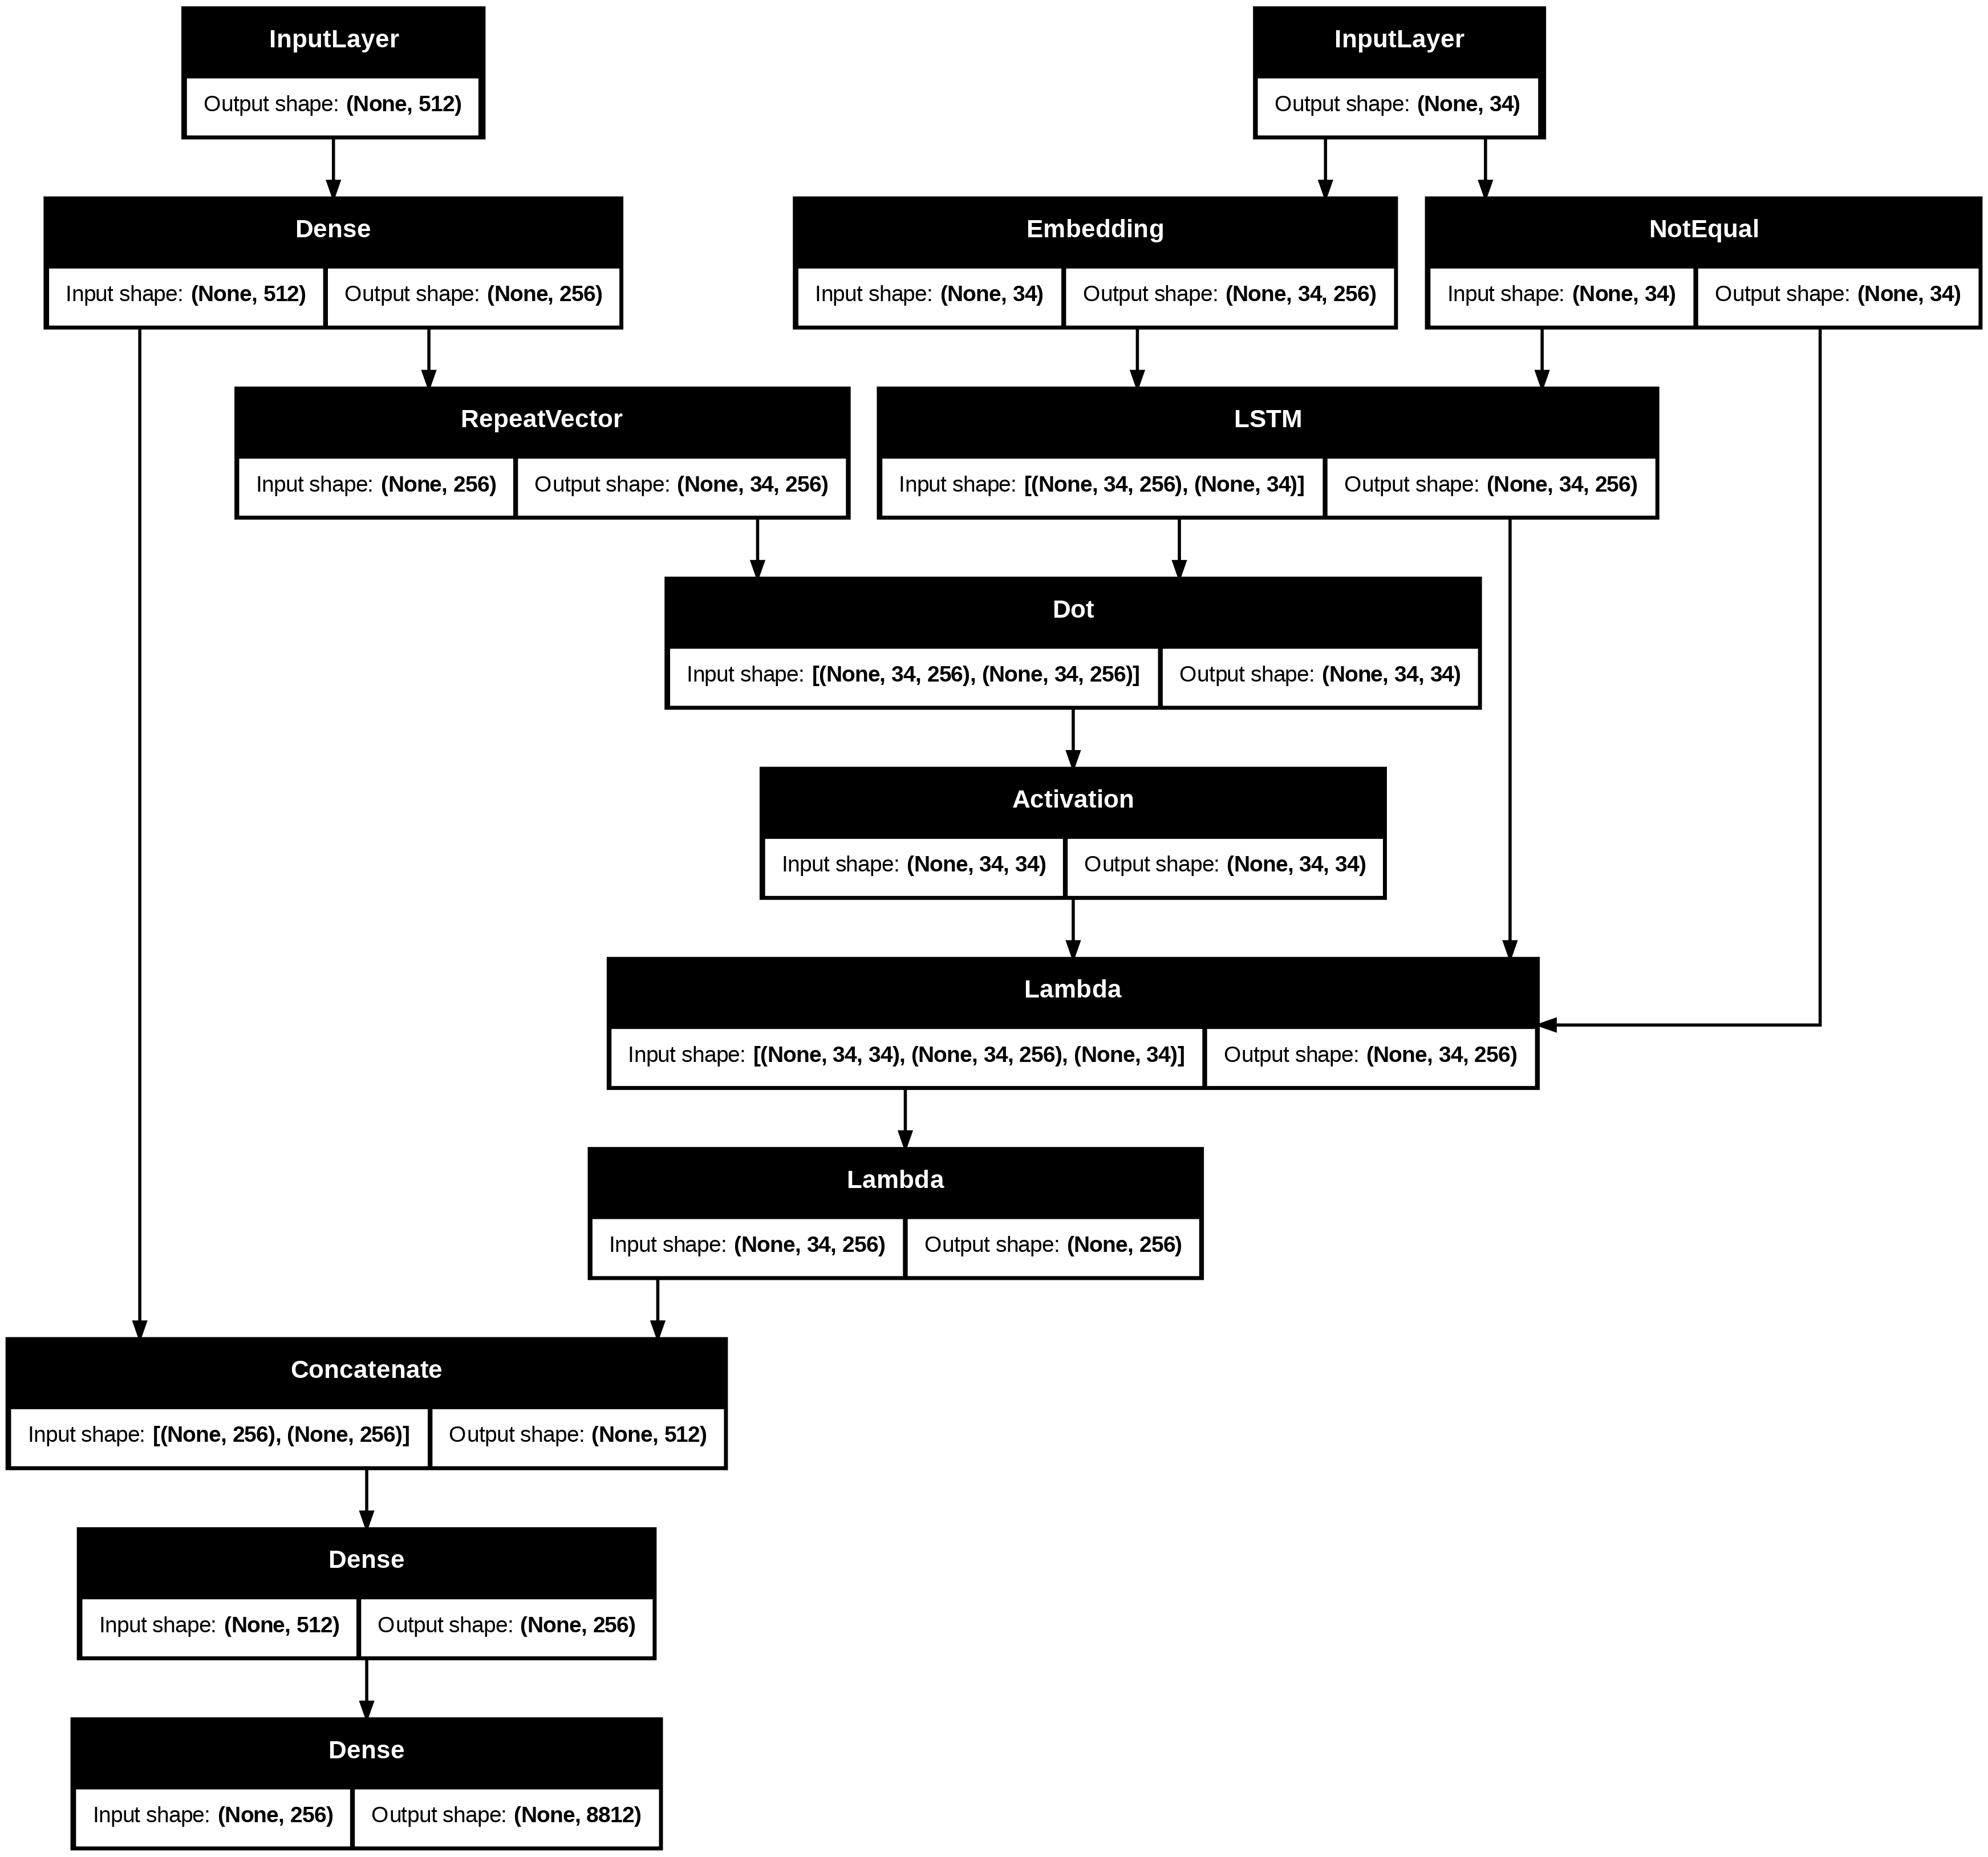

In [32]:
# Visualize the model
plot_model(model, show_shapes=True)

In [35]:
# Filter out image IDs that are missing features
valid_image_ids = [image_id for image_id in image_to_caption_mapping.keys() if image_id in loaded_features]

# Split valid image IDs into training and testing sets
train, test = train_test_split(valid_image_ids, test_size=0.1, random_state=42)

# Log the number of valid images
print(f"Total valid images: {len(valid_image_ids)}")
print(f"Training images: {len(train)}, Testing images: {len(test)}")


Total valid images: 8091
Training images: 7281, Testing images: 810


Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 5.2799
Epoch 1: val_loss improved from inf to 5.51417, saving model to /content/drive/MyDrive/Vision-Language-Model/Output/best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 71s 309ms/step - loss: 5.2799 - val_loss: 5.5142 - learning_rate: 0.0010
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 5.2937
Epoch 2: val_loss improved from 5.51417 to 5.18380, saving model to /content/drive/MyDrive/Vision-Language-Model/Output/best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 63s 277ms/step - loss: 5.2935 - val_loss: 5.1838 - learning_rate: 0.0010
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 5.1221
Epoch 3: val_loss improved from 5.18380 to 5.04540, saving model to /content/drive/MyDrive/Vision-Language-Model/Output/best_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 63s 276ms/step - loss: 5.1220 - val_loss: 5.0454 - learning_rate: 0.0010
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 5.0539
Epoch 4: va

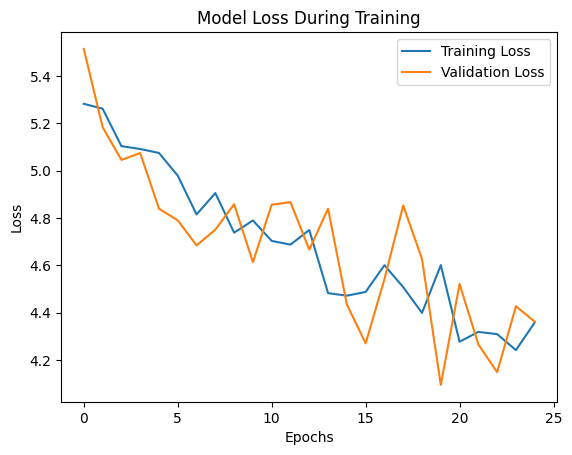

In [36]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set training parameters
epochs = 50
batch_size = 32

# Calculate steps per epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),  # Stop training when validation loss stops improving
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),  # Save the best model during training
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )  # Reduce learning rate when validation loss plateaus
]

# Set up data generators
train_generator = data_generator(
    train, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size
)
test_generator = data_generator(
    test, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save(os.path.join(OUTPUT_DIR, 'clip_model.keras'))

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
plt.show()


In [37]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm

def get_word_from_index(index, tokenizer):
    """Retrieve a word from the tokenizer's word_index based on its index."""
    return tokenizer.index_word.get(index, None)

def predict_caption(model, image_features, tokenizer, max_caption_length):
    """Generate a caption for an image using the trained model."""
    caption = ['startseq']

    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

        # Append the predicted word to the caption
        caption.append(predicted_word)

    # Return the caption excluding the start sequence tag
    return ' '.join(caption[1:])

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for image_id in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_caption_mapping[image_id]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(
        model,
        loaded_features[image_id].reshape(1, -1),  # Ensure the feature shape matches the model input
        tokenizer,
        max_caption_length
    )

    # Append the actual and predicted captions to the lists
    actual_captions_list.append([caption.split() for caption in actual_captions])  # Split into words
    predicted_captions_list.append(predicted_caption.split())  # Split into words

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25)))


  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.233753
BLEU-2: 0.103607
BLEU-3: 0.025425
BLEU-4: 0.000000


In [40]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_caption_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
man in the


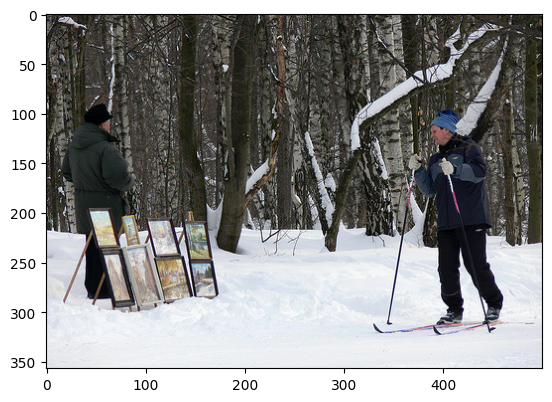

In [41]:
generate_caption("101669240_b2d3e7f17b.jpg")